# MNIST

FC network on the MNIST dataset

# Guided exercise


- The code will run but the network will not train: we will read carefully the code together
and try to figure out where the problem is.

Then you should (we will do it together anyway...)

- Run it and plot training and test loss and error

- Experiment a bit with changing the hidden layer size

- Define a new network with two hidden layers of sizes [50,30] 
and train it for a few epochs

- Write a function to extract representations in both hidden layers

- Change loss function by adding a L2 regularization (see documentation and the implementation of 
    optim.SGD)
  can you make sense of what exactly happens there? This is also key if you want to modify the learning
  rule by yourself, be it applying L1 regularization or define some fancier learning rules.
  On may want, for example, to *block* learning of just one parameter or a group of parameters, but
  not all the parameters of a *group*, like all the parameters in a layer.
  This could be only done (to my knowledge) by customized manipulations such as for example
  *masking*, we will discuss it for the exam.
  
- Make a T-SNE 2D visualization of the representations in the two
hidden layers with $N=1000$ test samples. (Solution: you may want to define a new
loader (custom_loader) for this purpose, and once you have it you may need to sample from it
sample = next(iter(custom_loader)))
)


Now, for the rest of this day, you can experiment by yourself or retrace some of our passages.
You don't have to submit anything, just try whatever you want.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [101]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
class FCNet(nn.Module):
    def __init__(self,din=784, dh=30, dout=10):
        super(FCNet, self).__init__()
        
        self.lin1 = nn.Linear(din, dh)
        self.lin2 = nn.Linear(dh, dout)
    
    def forward(self, x):    
        x = torch.sigmoid(self.lin1(x)) 
        return  F.log_softmax(self.lin2(x))  


In [88]:
# Add another hidden layer
class DeeperFCNet(nn.Module):
    def __init__(self,din=784, dh1=50, dh2=30, dout=10):
        super(DeeperFCNet, self).__init__()
        
        self.lin1 = nn.Linear(din, dh1)
        
        self.lin2 = nn.Linear(dh1, dh2)
        
        self.lin3 = nn.Linear(dh2, dout)
    
    def forward(self, x):
        
        x = torch.sigmoid(self.lin1(x))
        
        x = torch.sigmoid(self.lin2(x))
        
        return  F.log_softmax(self.lin3(x), dim=1)  
    
    
    def extract(self, x):
        
        h1 = torch.sigmoid(self.lin1(x))
        
        h2 = torch.sigmoid(self.lin2(h1))
        
        return h1, h2
        

Questions:
- is this a *deep* network?
- how many hidden layers do we have?
- what is the number of parameters?
- how to you forward pass an input data?

In [28]:
#F.nll_loss?

[o1,o2,....o10]

max is o2 ---> "1"
y == 1 'hit'
otherwise 'miss'

n.of hits/n.of samples = accuracy

In [74]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1,784)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = F.nll_loss(output, target)
        
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        

In [75]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1,784)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [76]:
# Training settings
input_size=(784,)
batch_size=64
test_batch_size=1000
epochs=10
lr=0.01
momentum=0.0   
seed=1
log_interval=100

In [77]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [78]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)

In [79]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [81]:
model = FCNet().to(device)

In [82]:
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]          23,550
            Linear-2                   [-1, 10]             310
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09
----------------------------------------------------------------


<ipython-input-25-0a3da533f251>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return  F.log_softmax(self.lin2(x))


In [83]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [84]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

<ipython-input-25-0a3da533f251>:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return  F.log_softmax(self.lin2(x))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.365362
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.068360


KeyboardInterrupt: 

# Deeper net

In [89]:
model3 = DeeperFCNet().to(device)

In [90]:
optimizer3 = optim.SGD(model3.parameters(), lr=lr, momentum=momentum)

In [91]:
for epoch in range(1, epochs + 1):
    train(model3, device, train_loader, optimizer3, epoch)
    test(model3, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376982
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.313016
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.310894
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.295520
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.295826
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.284621
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.294396
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.269699
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.259675
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.261403

Test set: Average loss: 2.2612, Accuracy: 1811/10000 (18%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.259334
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.248646
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.238688
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.247249
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.225831
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.213767
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.204921
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.210513
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.151957
T

In [92]:
test_batch_size

1000

In [97]:
sample = next(iter(test_loader))[0].view(-1, 784)

In [98]:
sample.shape

torch.Size([1000, 784])

In [109]:
r1, r2 = model3.extract(sample)

In [103]:
print(r1.shape)

torch.Size([1000, 50])


In [110]:
r1 = r1.detach().numpy()
r2 = r2.detach().numpy()

In [ ]:
#h1 = h1.detach().numpy()
#h2 = h2.detach().numpy()

In [111]:
e1 = TSNE(n_components=2).fit_transform(r1)
e2 = TSNE(n_components=2).fit_transform(r2)

In [112]:
e1.shape

(1000, 2)

In [113]:
r1.shape

(1000, 50)

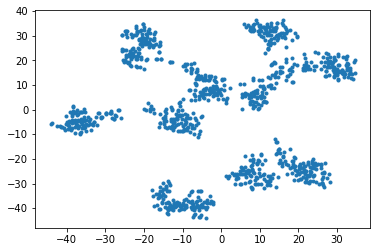

In [114]:
plt.plot(e1[:,0],e1[:,1], '.')

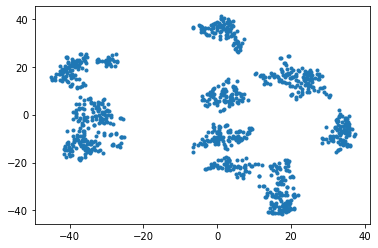

In [115]:
plt.plot(e2[:,0],e2[:,1], '.')

In [116]:
# Density peak clustering

In [ ]:
x -> h1 -> h2 -....-> 

In [124]:
out = model3(sample)

In [125]:
out = out.detach().numpy()

In [126]:
e3 = TSNE(n_components=2).fit_transform(out)

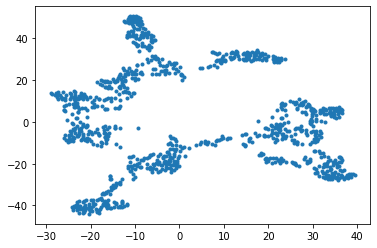

In [127]:
plt.plot(e3[:,0],e3[:,1], '.')

$\theta$ = $\theta$ - $\alpha$ ( grad L + $\lambda$ $\theta$) 

In [130]:
optim.SGD??

Init signature:
optim.SGD(
    params,
    lr=<required parameter>,
    momentum=0,
    dampening=0,
    weight_decay=0,
    nesterov=False,
)
Source:        
class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), targ